In [1]:
import numpy as np
import pickle
import pandas as pd
from tqdm import tqdm
from math import log
from scipy.sparse import coo_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import mode

In [2]:
with open('./info.pkl', 'rb') as f:
    info = pickle.load(f)
    num_user = info['num_user']
    num_item = info['num_item']

train_df = pd.read_csv('./train_df.csv')

train_like = list(np.load('./user_train_like.npy', allow_pickle=True))
test_like = list(np.load('./user_test_like.npy', allow_pickle=True))

In [3]:
pos_user_array = train_df['userId'].values
pos_item_array = train_df['itemId'].values
train_mat = coo_matrix((np.ones(len(pos_user_array)), (pos_user_array, pos_item_array)), shape=(num_user, num_item)).toarray()

user_pop = np.sum(train_mat, axis=1)
item_pop = np.sum(train_mat, axis=0)
user_item_pop = np.sum(train_mat * item_pop.reshape((1, -1)), axis=1) / (np.sum(train_mat, axis=1) + 1e-7)

Rec = np.load('./Rec_DC.npy')

In [4]:
top1 = 1
top2 = 5
top3 = 10
top4 = 20
k_set = [top1, top2, top3, top4]
def user_precision_recall_ndcg(new_user_prediction, test):
    dcg_list = []

    # compute the number of true positive items at top k
    count_1, count_5, count_10, count_15 = 0, 0, 0, 0
    for i in range(k_set[3]):
        if i < k_set[0] and new_user_prediction[i] in test:
            count_1 += 1.0
        if i < k_set[1] and new_user_prediction[i] in test:
            count_5 += 1.0
        if i < k_set[2] and new_user_prediction[i] in test:
            count_10 += 1.0
        if new_user_prediction[i] in test:
            count_15 += 1.0
            dcg_list.append(1)
        else:
            dcg_list.append(0)

    # calculate NDCG@k
    idcg_list = [1 for i in range(len(test))]
    ndcg_tmp_1 = NDCG_at_k(dcg_list, idcg_list, k_set[0])
    ndcg_tmp_5 = NDCG_at_k(dcg_list, idcg_list, k_set[1])
    ndcg_tmp_10 = NDCG_at_k(dcg_list, idcg_list, k_set[2])
    ndcg_tmp_15 = NDCG_at_k(dcg_list, idcg_list, k_set[3])

    # precision@k
    precision_1 = count_1 * 1.0 / k_set[0]
    precision_5 = count_5 * 1.0 / k_set[1]
    precision_10 = count_10 * 1.0 / k_set[2]
    precision_15 = count_15 * 1.0 / k_set[3]

    l = len(test)
    if l == 0:
        l = 1
    # recall@k
    recall_1 = count_1 / l
    recall_5 = count_5 / l
    recall_10 = count_10 / l
    recall_15 = count_15 / l

    # return precision, recall, ndcg_tmp
    return np.array([precision_1, precision_5, precision_10, precision_15]), \
           np.array([recall_1, recall_5, recall_10, recall_15]), \
           np.array([ndcg_tmp_1, ndcg_tmp_5, ndcg_tmp_10, ndcg_tmp_15])

def NDCG_at_k(predicted_list, ground_truth, k):
    dcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(predicted_list[:k])]
    dcg = np.sum(dcg_value)
    if len(ground_truth) < k:
        ground_truth += [0 for i in range(k - len(ground_truth))]
    idcg_value = [(v / log(i + 1 + 1, 2)) for i, v in enumerate(ground_truth[:k])]
    idcg = np.sum(idcg_value)
    return dcg / idcg

In [5]:
user_precision = []
user_recall = []
user_ndcg = []
for u in range(num_user):
    Rec[u, train_like[u]] = -100000.0

for u in tqdm(range(num_user)):
    scores = Rec[u, :]
    top_iid = np.argpartition(scores, -20)[-20:]
    top_iid = top_iid[np.argsort(scores[top_iid])[-1::-1]]

    # calculate the metrics
    if not len(test_like[u]) == 0:
        precision_u, recall_u, ndcg_u = user_precision_recall_ndcg(top_iid, test_like[u])
    else:
        precision_u = recall_u = ndcg_u = [-1, -1, -1, -1]
    user_precision.append(precision_u)
    user_recall.append(recall_u)
    user_ndcg.append(ndcg_u)

100%|██████████| 6040/6040 [00:01<00:00, 3662.60it/s]


In [6]:
ndcg = np.array(user_ndcg)[:, 3]

In [7]:
np.mean(user_ndcg, axis=0)

array([0.38592715, 0.33783531, 0.32049295, 0.31695019])

In [8]:
MS_similarity = np.load('./MS_similarity.npy')
MS_density = np.load('./MS_density.npy')
MS_distribution = np.load('./MS_distribution.npy')
MS_DeepSVDD = np.load('./MS_DeepSVDD.npy')

In [9]:
def distribution_plot(x, y, bins=20):
    x_max = np.max(x)
    x_min = np.min(x)
    step = (x_max - x_min) / bins
    x_array = []
    mean_array = []
    std_array = []
    for i in range(bins):
        start = x_min + step * i
        end = x_min + step * (i + 1)
        x_array.append((start + end) / 2)
        tmp = y[np.where((x >= start) & (x <= end))[0]]
        mean_array.append(np.mean(tmp) if len(tmp) > 0 else 0)
        std_array.append(np.std(tmp) if len(tmp) > 0 else 0)
    print(mean_array)
    plt.rcParams.update({'font.size': 15})
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 3))
    axes.bar(x_array, mean_array, yerr=std_array, align='center', alpha=0.7, ecolor='black', capsize=5, width=step / 2)
    axes.grid(True)
    axes.set_ylim(0., 0.6)
    fig.tight_layout()
    fig.patch.set_facecolor('white')
    plt.show()
    

[0.21921327001062763, 0.2668721417906829, 0.29064663610440744, 0.35608955268588294, 0.451929333227941]


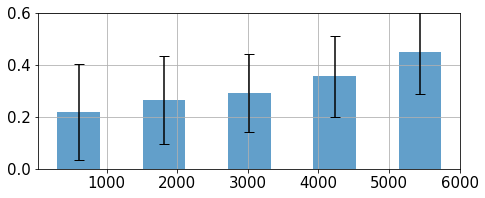

In [10]:
user_sort_idx = np.argsort(MS_similarity)
distribution_plot(np.arange(num_user), ndcg[user_sort_idx], bins=5)

[0.23422913426579522, 0.26733698123079863, 0.2775944892237108, 0.34074744038779337, 0.4648428887114438]


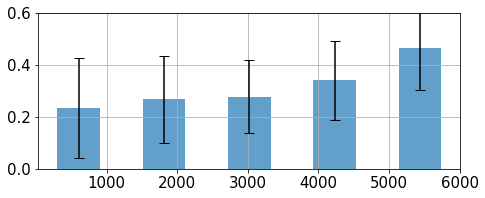

In [11]:
user_sort_idx = np.argsort(MS_density)
distribution_plot(np.arange(num_user), ndcg[user_sort_idx], bins=5)

[0.21912562934504975, 0.2673130189512472, 0.2857133715040508, 0.34028138009230957, 0.4723175339268846]


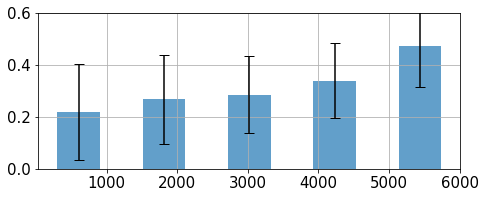

In [12]:
user_sort_idx = np.argsort(MS_distribution)
distribution_plot(np.arange(num_user), ndcg[user_sort_idx], bins=5)

[0.22232813700657053, 0.2655171411043613, 0.28242783594125326, 0.3346715449395237, 0.479806274827833]


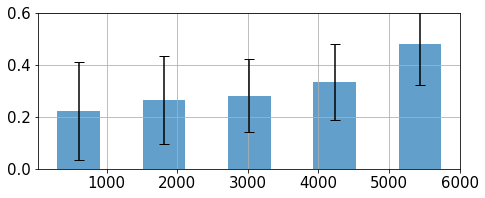

In [13]:
user_sort_idx = np.argsort(MS_DeepSVDD)
distribution_plot(np.arange(num_user), ndcg[user_sort_idx], bins=5)